In [9]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
%matplotlib inline

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [69]:
df = pd.read_csv('TSLA.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 7 columns):
Date      441 non-null object
minor     441 non-null object
Close     441 non-null float64
High      441 non-null float64
Low       441 non-null float64
Volume    441 non-null float64
Open      441 non-null float64
dtypes: float64(5), object(2)
memory usage: 24.2+ KB


In [70]:
df.Date = df.Date.astype('datetime64[ns]')

In [71]:
df.drop('minor', axis=1, inplace=True)

In [72]:
df.set_index(df.Date)

,Date,Close,High,Low,Volume,Open
Date,,,,,,
2015-12-31,2015-12-31,240.009995,243.449997,238.369995,2715000.0,238.509995
2016-01-04,2016-01-04,223.410004,231.380005,219.000000,6827100.0,230.720001
2016-01-05,2016-01-05,223.429993,226.889999,220.000000,3186800.0,226.360001
2016-01-06,2016-01-06,219.039993,220.050003,215.979996,3779100.0,220.000000
2016-01-07,2016-01-07,215.649994,218.440002,213.669998,3554300.0,214.190002
2016-01-08,2016-01-08,211.000000,220.440002,210.770004,3628100.0,217.860001
2016-01-11,2016-01-11,207.850006,214.449997,203.000000,4089700.0,214.009995
2016-01-12,2016-01-12,209.970001,213.740005,205.309998,3091900.0,211.600006
2016-01-13,2016-01-13,200.309998,212.649994,200.000000,4126400.0,212.009995


In [73]:
df.drop('Date', axis=1, inplace=True)

In [74]:
df = df[['Open', 'High', 'Low', 'Volume','Close']]

In [75]:
df['NextClose'] = df['Close'].shift(-1)

In [76]:
df.head(10)

,Open,High,Low,Volume,Close,NextClose
0,238.509995,243.449997,238.369995,2715000.0,240.009995,223.410004
1,230.720001,231.380005,219.000000,6827100.0,223.410004,223.429993
2,226.360001,226.889999,220.000000,3186800.0,223.429993,219.039993
3,220.000000,220.050003,215.979996,3779100.0,219.039993,215.649994
4,214.190002,218.440002,213.669998,3554300.0,215.649994,211.000000
5,217.860001,220.440002,210.770004,3628100.0,211.000000,207.850006
6,214.009995,214.449997,203.000000,4089700.0,207.850006,209.970001
7,211.600006,213.740005,205.309998,3091900.0,209.970001,200.309998
8,212.009995,212.649994,200.000000,4126400.0,200.309998,206.179993
9,202.210007,210.000000,193.380005,6490700.0,206.179993,204.990005


In [77]:
df.shape

(441, 6)

In [79]:
df = df[:-1]

In [80]:
df.tail(3)

,Open,High,Low,Volume,Close,NextClose
437,350.929993,351.23999,340.899994,7156300.0,345.250000,340.970001
438,349.899994,351.48999,340.500000,6060300.0,340.970001,339.600006
439,339.880005,342.75000,335.399994,5319600.0,339.600006,341.100006


In [81]:
data = df.values

In [82]:
data[:3]

array([[  2.38509995e+02,   2.43449997e+02,   2.38369995e+02,
          2.71500000e+06,   2.40009995e+02,   2.23410004e+02],
       [  2.30720001e+02,   2.31380005e+02,   2.19000000e+02,
          6.82710000e+06,   2.23410004e+02,   2.23429993e+02],
       [  2.26360001e+02,   2.26889999e+02,   2.20000000e+02,
          3.18680000e+06,   2.23429993e+02,   2.19039993e+02]])

In [84]:
data.shape

(440, 6)

In [83]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

In [85]:
dataset = scaled.copy()

In [87]:
# Split data into train (80%) and test (20%) dataset 
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(dataset), len(train), len(test))
print(dataset.shape, train.shape, test.shape)

440 352 88
(440, 6) (352, 6) (88, 6)


In [91]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

[[ 0.39362438  0.37708831  0.40839274  0.04779716  0.39920439]
 [ 0.36174651  0.32564784  0.32710867  0.23400912  0.33041895]
 [ 0.34390472  0.30651212  0.33130506  0.06916211  0.33050178]
 ..., 
 [ 0.69763058  0.67933858  0.69555175  0.12089445  0.69067255]
 [ 0.68805495  0.66382552  0.68161983  0.12040538  0.66377983]
 [ 0.67189101  0.66497617  0.68967683  0.15277885  0.69013385]]
(352, 5) (352,)
(88, 5) (88,)


In [92]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(352, 1, 5) (352,) (88, 1, 5) (88,)


In [97]:
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

In [99]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model_result = model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=2,shuffle=False )

Epoch 1/100
2s - loss: 0.0437
Epoch 2/100
2s - loss: 0.0116
Epoch 3/100
2s - loss: 0.0061
Epoch 4/100
2s - loss: 0.0031
Epoch 5/100
2s - loss: 0.0017
Epoch 6/100
2s - loss: 0.0011
Epoch 7/100
2s - loss: 8.6616e-04
Epoch 8/100
2s - loss: 7.7078e-04
Epoch 9/100
2s - loss: 7.3682e-04
Epoch 10/100
2s - loss: 7.2966e-04
Epoch 11/100
2s - loss: 7.3566e-04
Epoch 12/100
2s - loss: 7.4840e-04
Epoch 13/100
2s - loss: 7.6566e-04
Epoch 14/100
2s - loss: 7.8482e-04
Epoch 15/100
2s - loss: 8.0394e-04
Epoch 16/100
3s - loss: 8.2137e-04
Epoch 17/100
3s - loss: 8.3560e-04
Epoch 18/100
2s - loss: 8.4589e-04
Epoch 19/100
2s - loss: 8.5206e-04
Epoch 20/100
2s - loss: 8.5472e-04
Epoch 21/100
2s - loss: 8.5459e-04
Epoch 22/100
2s - loss: 8.5255e-04
Epoch 23/100
2s - loss: 8.4930e-04
Epoch 24/100
2s - loss: 8.4544e-04
Epoch 25/100
2s - loss: 8.4130e-04
Epoch 26/100
2s - loss: 8.3717e-04
Epoch 27/100
2s - loss: 8.3325e-04
Epoch 28/100
2s - loss: 8.2995e-04
Epoch 29/100
2s - loss: 8.2634e-04
Epoch 30/100
2s - 

In [219]:
score = model.evaluate(test_, y_test, batch_size=32)

In [102]:
# make predictions
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

In [109]:
print(test_X.shape, testPredict.shape)

(88, 1, 5) (88, 1)


Sample shape

train_X.shape trainPredict.shape

(352, 1, 5)    (352, 1)

test_X.shape, testPredict.shape

(88, 1, 5) (88, 1)

In [117]:
train_X.reshape(len(train_X),train_X.shape[2]).shape

(352, 5)

In [129]:
def reshape_to_orig(x,y):
    '''
    Merging x and y into its original series shape.
    
    Reshape x from (rows_count,1,cols_count) => (rows_count,cols_count) 
    and concat with y in the shape (rows_count,1)
    e.g (88, 1, 5) + (88, 1) = (88,6)
    
    '''
    return np.hstack((x.reshape(len(x),x.shape[2]), y))

In [137]:
#trainPredict2 = np.hstack((train_X[:].reshape(len(train_X),train_X.shape[2]), trainPredict))
trainPredict2 = reshape_to_orig(train_X,trainPredict)
trainY2 = reshape_to_orig(train_X,train_y)
testPredict2 = reshape_to_orig(test_X,testPredict)
testY2 = reshape_to_orig(test_X,test_y)
print(trainPredict2.shape, trainY2.shape)
print(testPredict2.shape, testY2.shape)
print(trainPredict2[:3])
trainPredict[:3,-1]

(352, 6) (352, 6)
(88, 6) (88, 6)
[[ 0.39362438  0.37708831  0.40839274  0.04779716  0.39920439  0.44638792]
 [ 0.36174651  0.32564784  0.32710867  0.23400912  0.33041895  0.38401714]
 [ 0.34390472  0.30651212  0.33130506  0.06916211  0.33050178  0.37868974]]


array([ 0.44638792,  0.38401714,  0.37868974], dtype=float32)

In [142]:
# Transform back to the original data sets
trainPredict_orig = scaler.inverse_transform(trainPredict2)
trainY_orig = scaler.inverse_transform(trainY2)
testPredict_orig = scaler.inverse_transform(testPredict2)
testY_orig = scaler.inverse_transform(testY2)


# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY_orig[:,-1], trainPredict_orig[:,-1]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY_orig[:,-1], testPredict_orig[:,-1]))
print('Test Score: %.3f RMSE' % (testScore))


Train Score: 12.622 RMSE
Test Score: 21.843 RMSE


In [144]:
print(trainPredict_orig[:3])
trainPredict_orig[:3,-1]

[[  2.38509995e+02   2.43449997e+02   2.38369995e+02   2.71500000e+06
    2.40009995e+02   2.51396795e+02]
 [  2.30720001e+02   2.31380005e+02   2.19000000e+02   6.82710000e+06
    2.23410004e+02   2.36344855e+02]
 [  2.26360001e+02   2.26889999e+02   2.20000000e+02   3.18680000e+06
    2.23429993e+02   2.35059193e+02]]


array([ 251.39679485,  236.34485509,  235.05919278])

In [164]:
data.shape, trainPredict_orig.shape[0]+testPredict_orig.shape[0]

((440, 6), 440)

In [174]:
data[:4], data[:4,-2]
print(train_size )

352


(440, 1) (1, 1)


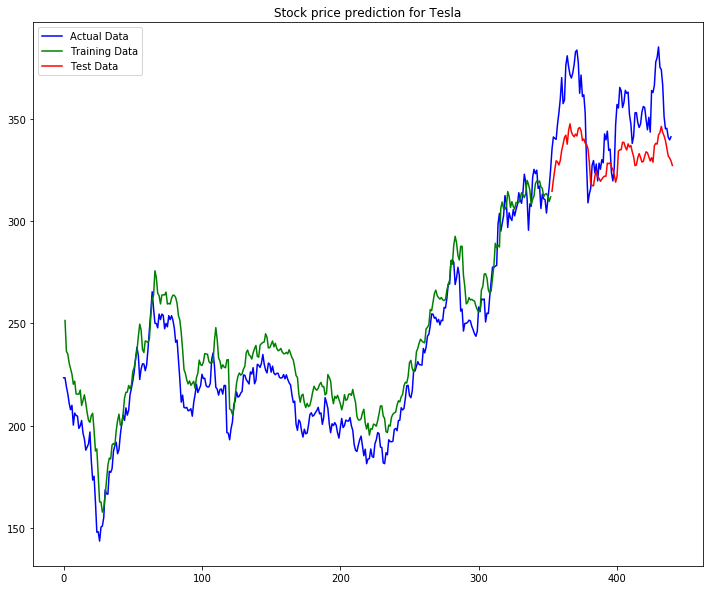

In [212]:
# The y value from the prediction at row1 is compare against the 'Close' price at row2
# And we need to shift the row data a bit to graph it correctly

# The actual 'Close' Price is 2nd col from the right
data_plot = data[:,-2].reshape(-1,1)
#print(data_plot.shape)
#print(data_plot[:3])

train_plot = np.empty_like(data_plot)
train_plot[:,:] = np.nan
#The prediction price is the last col
train_plot[1:train_size+1,:] = trainPredict_orig[:,-1].reshape(-1,1)
#train[look_back:len(trainPredict4)+look_back, :] = trainPredict4
#print(train_plot.shape)
#print(train_plot[:3])

test_plot = np.empty_like(data_plot)
# The Test prediction contain the prediction data for next day 
# hence, we add 1 more empty row to graph it 
empty_row = np.array([[np.nan]])
print(test_plot.shape, empty_row.shape)
test_plot = np.concatenate((test_plot,empty_row), axis=0)
test_plot[:,:] = np.nan
#print('Test')
#print(len(test_plot) - (train_size+1))
#print(len(testPredict))
test_plot[train_size+1:len(test_plot),:] = testPredict_orig[:,-1].reshape(-1,1)
#print(test_plot.shape)
#print(test_plot[:-3])

plt.figure(figsize=(12,10))
plt.plot(data[:,-1], color='blue', label='Actual Data')
plt.plot(train_plot[:,-1], color='green', label='Training Data')
plt.plot(test_plot[:,-1], color='red', label='Test Data')
plt.title('Stock price prediction for Tesla')
plt.legend()
plt.show()

In [215]:
data[-10:].shape

(10, 6)

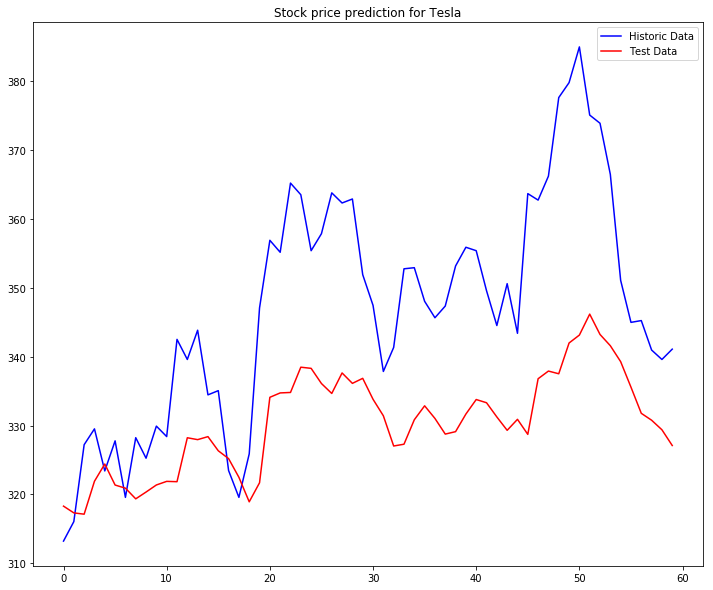

In [218]:
plt.figure(figsize=(12,10))
plt.plot(data[-60:,-1], color='blue', label='Historic Data')
plt.plot(test_plot[-60:,-1], color='red', label='Test Data')
plt.title('Stock price prediction for Tesla')
plt.legend()
plt.show()
